In [3]:
#%reset
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as sk
import keras
import tensorflow as tf
from sklearn import metrics
from keras import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, matthews_corrcoef,
                             roc_auc_score, make_scorer)
from sklearn.model_selection import (cross_validate, RandomizedSearchCV,
                                     RepeatedStratifiedKFold)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from eli5.sklearn import PermutationImportance
from matplotlib.patches import Polygon
from scipy.stats import loguniform
from tensorflow import random
from keras.metrics import AUC
from sklearn.feature_selection import SelectFromModel
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'REGION', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75',
       'Trend_N_greater_75'],
      dtype='object')


In [4]:


################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
best_hyperparameters_by_year = {}

space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}

# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_nn,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models_sd = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))


oversample = RandomOverSampler(sampling_strategy='minority', random_state=10)

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    important_features = []

    for q in PI.importances_mean.argsort()[::-1]:
        if (PI.importances_mean[q] - PI.importances_std[q] >=0) & (PI.importances_mean[q] >0):

            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    feature_importances_dict = {feature_names[i]: PI.importances_mean[i] for i in range(len(feature_names))}
    feature_importances = [feature_importances_dict[feature] for feature in feature_names]

    return important_features, feature_importances

def get_feature_effects_sd(feature_names, important_features,model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )

    return PI.importances_std

def get_best_hyperparameters(model, cv, space, X_train, y_train, sample_weights):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=20, n_jobs=-1, cv=cv, random_state=1
    )
    if model_type == 2:
            result = search.fit(X_train, y_train)
    else: 
        result = search.fit(X_train, y_train, sample_weight = sample_weights)
    return result.best_params_

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):
    feature_names_with_weight = feature_names.copy()
    feature_names_with_weight.extend(['weight'])
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[feature_names_with_weight]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names_with_weight]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)

    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    weights_train = X_train["weight"]
    X_train  = X_train.drop("weight", axis = 1)
    X_test = X_test.drop("weight", axis = 1)

    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train)

In [155]:
# Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
i = 0
test_years = np.array(range(2005, 2011))

for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))
    best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features, imporances_all_models[i + indices_for_importance[model_type]] = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    #imporances_all_models[i + indices_for_importance[model_type]],  = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    #imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))

    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 


    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_lr_" + str(year) + "_no_weights.sav" 

    pickle.dump(model_lr, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    print(metrics.roc_auc_score(y_test, y_predict_proba[:,1]))
    ROC_by_year[model_type].__setitem__(year, roc_auc_score(y_test, y_predict_proba[:,1]))
    #ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    print(ROC)
    i += 1

2005


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7325302430724117
0.7362402908336643
2006


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7898353173728128
0.7163785879790616
2007


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7239025441773911
0.6669594209648918
2008


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7208127102511278
0.6607501238688815
2009


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.759536063635699
0.6709662122627598
2010


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1
0.761359967373018
0.6804865442021966


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

In [156]:
## Just RF
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

space = dict()
space['criterion'] = ['gini', 'entropy']
space['n_estimators'] = np.arange(1, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 100, 1)
space['min_samples_leaf'] = np.arange(1, 100, 1)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    model_rf = RandomForestClassifier(criterion = best_hyperparameters1['criterion'],n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
  
    important_features, imporances_all_models[i + indices_for_importance[model_type]] = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))

    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(criterion = best_hyperparameters1['criterion'], n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    #ROC_predict_proba_rf.append(metrics.roc_auc_score(y_test, y_predict_proba[:,1]))
    model_name = "CIP_rf_" + str(year) + "_no_weights.sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC_by_year[model_type].__setitem__(year, roc_auc_score(y_test, y_predict_proba[:,1]))
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

2005
Oversample
Oversample
2006
Oversample
Oversample
2007
Oversample
Oversample
2008
Oversample
Oversample
2009
Oversample
Oversample
2010
Oversample
Oversample


In [16]:
best_hyperparameters_by_year[2]= {2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}


In [84]:
best_features_by_year

[{2005: ['MSW',
   'Trend_N_greater_75',
   'Northeast',
   'Count_Exceeds_75',
   'MSMW',
   'Southwest'],
  2006: ['West', 'Southwest', 'Northeast', 'MSW', 'MSMW'],
  2007: ['PREV_CLINIC',
   'West',
   'Southeast',
   'Trend_N_greater_75',
   'Count_Exceeds_75'],
  2008: ['West', 'PREV_CLINIC', 'Count_Exceeds_75', 'Oth/Unk/Missing'],
  2009: ['PREV_CLINIC',
   'West',
   'DELTA_CLINIC',
   'MSM',
   'Northeast',
   'MSW',
   'Oth/Unk/Missing',
   'Southwest',
   'Count_Exceeds_75'],
  2010: ['PREV_CLINIC',
   'DELTA_CLINIC',
   'MSW',
   'West',
   'PREV_REGION',
   'Oth/Unk/Missing',
   'MSM',
   'Southeast',
   'Count_Exceeds_75',
   'Northeast',
   'Southwest']},
 {2005: ['PREV_CLINIC',
   'MSW',
   'DELTA_CLINIC',
   'MSM',
   'DELTA_REGION',
   'West',
   'PREV_REGION',
   'Count_Exceeds_75',
   'MSMW',
   'Midwest',
   'Oth/Unk/Missing',
   'Southeast',
   'Trend_N_greater_75',
   'Northeast'],
  2006: ['PREV_CLINIC',
   'MSW',
   'MSM',
   'DELTA_CLINIC',
   'DELTA_REGION',
 

In [67]:
from sklearn.neural_network import MLPClassifier

# Just Neural Network
model_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', learning_rate_init=0.001)

space = dict()

i = 0
space['solver'] = ['adam']#['lbfgs', 'sgd', 'adam']
space['activation'] = ['tanh', 'relu']
space['alpha'] = [0.001, 0.01, 0.1]
space['learning_rate'] = ['constant','adaptive']
space['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}
test_years = np.array(range(2005, 2011))
for year in test_years:
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year))
    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')


    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train = get_test_train_data(CIP_data_no_drop=CIP_data_no_drop, year=year, feature_names=feature_names, years_train=years_train, model_type=model_type)
    weights_train = np.ones(len(X_train))
    
    #best_hyperparameters1 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train, weights_train)
    best_hyperparameters1 = best_hyperparameters_by_year[model_type][year]
    model_nn = MLPClassifier(hidden_layer_sizes=best_hyperparameters1['hidden_layer_sizes'],
                             activation=best_hyperparameters1['activation'],
                             solver=best_hyperparameters1['solver'],
                             alpha=best_hyperparameters1['alpha'],
                             learning_rate=best_hyperparameters1['learning_rate'],
                             max_iter=500)

    print("Hyperparameters1")
    model_fit = model_nn.fit(X_train, y_train)

    ## now also need to do feature engineering
    important_features, imporances_all_models.iloc[:,i + indices_for_importance[model_type]] = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))


    #best_hyperparameters2 = get_best_hyperparameters(model_nn, cv, space, X_train, y_train, weights_train)
    best_hyperparameters2 = best_hyperparameters_by_year[model_type][year]
    #best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 
    model_nn = MLPClassifier(hidden_layer_sizes=best_hyperparameters2['hidden_layer_sizes'],
                             activation=best_hyperparameters2['activation'],
                             solver=best_hyperparameters2['solver'],
                             alpha=best_hyperparameters2['alpha'],
                             learning_rate=best_hyperparameters2['learning_rate'],
                             max_iter=500)

    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)[:, 1]
    model_name = "CIP_nn_" + str(year) + "_no_weights.sav"

    pickle.dump(model_nn, open(model_name, 'wb'))
    
    print(metrics.roc_auc_score(y_test, y_predict_proba))
    ROC_by_year[model_type].__setitem__(year, roc_auc_score(y_test, y_predict_proba))
    
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis=1)
    i += 1

2005
Oversample
Hyperparameters1
Oversample
0.8075366177775817
2006
Oversample
Hyperparameters1
Oversample
0.8294240574822996
2007
Oversample
Hyperparameters1
Oversample
0.768237057738165
2008
Oversample
Hyperparameters1
Oversample
0.7663364800375518
2009
Oversample
Hyperparameters1
Oversample
0.7593076919440429
2010
Oversample
Hyperparameters1
Oversample
0.7551044799791548


In [81]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

# DATA TO USE - ALL FEATURES, NO WEIGHTS, CORRECT ITERATIONS, NO TENSORFLOW

[{2005: 0.7325302430724117, 2006: 0.7898353173728128, 2007: 0.7239025441773911, 2008: 0.7208127102511278, 2009: 0.759536063635699, 2010: 0.761359967373018}, {2005: 0.8178244111979052, 2006: 0.8328436843765796, 2007: 0.7698604735207576, 2008: 0.778190080058414, 2009: 0.7497728101682131, 2010: 0.7568635614389859},{2005: 0.8042861310933599,
 2006: 0.8300724748305736,
 2007: 0.7645538358707565,
 2008: 0.7599393694421989,
 2009: 0.7500586384319736,
 2010: 0.7555788740292623}]
[{2005: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}, 2009: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2010: {'solver': 'liblinear', 'penalty': 'l2', 'C': 34.34}}, {2005: {'n_estimators': 45, 'min_samples_split': 53, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'entropy'}, 2006: {'n_estimators': 45, 'min_samples_split': 53, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'entropy'}, 2007: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}, 2008: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}, 2009: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}, 2010: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}}, {2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}]
[{2005: ['MSW', 'Trend_N_greater_75', 'Northeast', 'Count_Exceeds_75', 'MSMW', 'Southwest'], 2006: ['West', 'Southwest', 'Northeast', 'MSW', 'MSMW'], 2007: ['PREV_CLINIC', 'West', 'Southeast', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2008: ['West', 'PREV_CLINIC', 'Count_Exceeds_75', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'DELTA_CLINIC', 'MSM', 'Northeast', 'MSW', 'Oth/Unk/Missing', 'Southwest', 'Count_Exceeds_75'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'West', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southeast', 'Count_Exceeds_75', 'Northeast', 'Southwest']}, {2005: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'DELTA_REGION', 'West', 'PREV_REGION', 'Count_Exceeds_75', 'MSMW', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Trend_N_greater_75', 'Northeast'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Midwest', 'Southeast', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Northeast', 'Midwest', 'Southwest', 'Trend_N_greater_75', 'Southeast', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Count_Exceeds_75', 'Midwest', 'Northeast', 'West', 'Oth/Unk/Missing', 'Trend_N_greater_75'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'Oth/Unk/Missing', 'West', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Southeast', 'Trend_N_greater_75'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Midwest', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southwest', 'Northeast', 'Southeast', 'Trend_N_greater_75']}, {2005: ['DELTA_REGION',
  'DELTA_CLINIC',
  'West',
  'MSW',
  'PREV_CLINIC',
  'MSM',
  'PREV_REGION',
  'Midwest',
  'Count_Exceeds_75',
  'MSMW',
  'Northeast',
  'Southwest',
  'Southeast',
  'Trend_N_greater_75',
  'Oth/Unk/Missing'],
 2006: ['DELTA_CLINIC',
  'PREV_REGION',
  'MSM',
  'PREV_CLINIC',
  'DELTA_REGION',
  'MSW',
  'West',
  'Midwest',
  'Southeast',
  'Northeast',
  'MSMW',
  'Trend_N_greater_75',
  'Southwest',
  'Count_Exceeds_75',
  'Oth/Unk/Missing'],
 2007: ['PREV_CLINIC',
  'DELTA_CLINIC',
  'MSM',
  'MSW',
  'DELTA_REGION',
  'West',
  'PREV_REGION',
  'MSMW',
  'Southeast',
  'Trend_N_greater_75',
  'Southwest',
  'Midwest',
  'Northeast'],
 2008: ['PREV_CLINIC',
  'DELTA_CLINIC',
  'MSW',
  'PREV_REGION',
  'MSM',
  'DELTA_REGION',
  'West',
  'Southeast',
  'MSMW',
  'Midwest',
  'Northeast',
  'Count_Exceeds_75',
  'Southwest',
  'Oth/Unk/Missing',
  'Trend_N_greater_75'],
 2009: ['PREV_CLINIC',
  'MSM',
  'DELTA_CLINIC',
  'MSW',
  'PREV_REGION',
  'West',
  'DELTA_REGION',
  'Southeast',
  'MSMW',
  'Southwest',
  'Midwest',
  'Oth/Unk/Missing',
  'Count_Exceeds_75',
  'Trend_N_greater_75'],
 2010: ['PREV_CLINIC',
  'MSM',
  'DELTA_CLINIC',
  'MSW',
  'PREV_REGION',
  'MSMW',
  'West',
  'Southeast',
  'DELTA_REGION',
  'Trend_N_greater_75',
  'Midwest',
  'Count_Exceeds_75',
  'Northeast',
  'Southwest']}]

In [85]:
2005
Oversample
Hyperparameters1




[{2005: 0.7359073044314007, 2006: 0.7898353173728128, 2007: 0.7211285053215495, 2008: 0.7225794716666234, 2009: 0.7582389269730606, 2010: 0.7609705394214373}, {2005: 0.8178244111979052, 2006: 0.8328436843765796, 2007: 0.7698604735207576, 2008: 0.778190080058414, 2009: 0.7497728101682131, 2010: 0.7568635614389859}, {2005: 0.8042861310933599, 2006: 0.8300724748305736, 2007: 0.7645538358707565, 2008: 0.7599393694421989, 2009: 0.7500586384319736, 2010: 0.7555788740292623}]
[[{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 36.26}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}], [{2005: {'n_estimators': 45, 'min_samples_split': 53, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'entropy'}, 2006: {'n_estimators': 45, 'min_samples_split': 53, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'entropy'}, 2007: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}, 2008: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}, 2009: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}, 2010: {'n_estimators': 195, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 86, 'criterion': 'gini'}}], [{2005: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2006: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2007: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2008: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2009: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}, 2010: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13,), 'alpha': 0.12080421346773286, 'activation': 'relu'}}]]
[{2005: ['MSW', 'Trend_N_greater_75', 'Northeast', 'Count_Exceeds_75', 'MSMW', 'Southwest'], 2006: ['West', 'Southwest', 'Northeast', 'MSW', 'MSMW'], 2007: ['PREV_CLINIC', 'West', 'Southeast', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2008: ['West', 'PREV_CLINIC', 'Count_Exceeds_75', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'DELTA_CLINIC', 'MSM', 'Northeast', 'MSW', 'Oth/Unk/Missing', 'Southwest', 'Count_Exceeds_75'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'West', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southeast', 'Count_Exceeds_75', 'Northeast', 'Southwest']}, {2005: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'DELTA_REGION', 'West', 'PREV_REGION', 'Count_Exceeds_75', 'MSMW', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Trend_N_greater_75', 'Northeast'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Midwest', 'Southeast', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Northeast', 'Midwest', 'Southwest', 'Trend_N_greater_75', 'Southeast', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'MSW', 'DELTA_CLINIC', 'MSM', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Count_Exceeds_75', 'Midwest', 'Northeast', 'West', 'Oth/Unk/Missing', 'Trend_N_greater_75'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'Oth/Unk/Missing', 'West', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Southeast', 'Trend_N_greater_75'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Midwest', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southwest', 'Northeast', 'Southeast', 'Trend_N_greater_75']}, {2005: ['DELTA_CLINIC', 'DELTA_REGION', 'West', 'MSM', 'MSW', 'PREV_CLINIC', 'PREV_REGION', 'Midwest', 'Count_Exceeds_75', 'MSMW', 'Northeast', 'Southwest', 'Trend_N_greater_75', 'Southeast', 'Oth/Unk/Missing'], 2006: ['DELTA_CLINIC', 'MSW', 'PREV_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'West', 'MSM', 'Midwest', 'MSMW', 'Northeast', 'Trend_N_greater_75', 'Southeast', 'Count_Exceeds_75'], 2007: ['DELTA_CLINIC', 'PREV_CLINIC', 'MSW', 'PREV_REGION', 'MSM', 'DELTA_REGION', 'West', 'Midwest', 'MSMW', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Count_Exceeds_75', 'Oth/Unk/Missing'], 2008: ['DELTA_CLINIC', 'PREV_CLINIC', 'MSM', 'MSW', 'PREV_REGION', 'Northeast', 'DELTA_REGION', 'MSMW', 'Midwest', 'Southeast', 'West', 'Southwest', 'Count_Exceeds_75', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSW', 'MSMW', 'Southeast', 'DELTA_REGION', 'West', 'Midwest', 'Trend_N_greater_75', 'Count_Exceeds_75', 'Northeast', 'Oth/Unk/Missing'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'West', 'DELTA_REGION', 'MSMW', 'Midwest', 'Trend_N_greater_75', 'Southwest', 'Southeast', 'Northeast', 'Count_Exceeds_75', 'Oth/Unk/Missing']}]

In [96]:
print(ROC_by_year)
print(best_hyperparameters_by_year)
print(best_features_by_year)

[{2005: 0.7359073044314007, 2006: 0.7898353173728128, 2007: 0.7211285053215495, 2008: 0.7225794716666234, 2009: 0.7582389269730606, 2010: 0.7609705394214373}, {2005: 0.8178244111979052, 2006: 0.8328436843765796, 2007: 0.7698604735207576, 2008: 0.778190080058414, 2009: 0.7497728101682131, 2010: 0.7568635614389859}, {2005: 0.8042861310933599, 2006: 0.8300724748305736, 2007: 0.7645538358707565, 2008: 0.7599393694421989, 2009: 0.7500586384319736, 2010: 0.7555788740292623}]
[[{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 36.26}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}], [{2005: {'n_estimators': 45, 'min_samples_split': 53, 'min_samples_leaf': 3, 'max_depth': 13, 'criterion': 'entropy'}, 2006: {'n_estimators': 45, 'min_samples_split

In [184]:
imporances_all_models.drop(0, axis = 1, inplace = True)

In [168]:
imporances_all_models.to_csv('imporances_all_models_no_weights_and_count_features.csv')

# auROC, features, and hyperparameters with weights caclulated by training set and extra features 


In [40]:
imporances_all_models= pd.read_csv('imporances_all_models_with_weights_and_count_features.csv')
imporances_all_models.drop(['Unnamed: 0'], axis = 1, inplace = True)

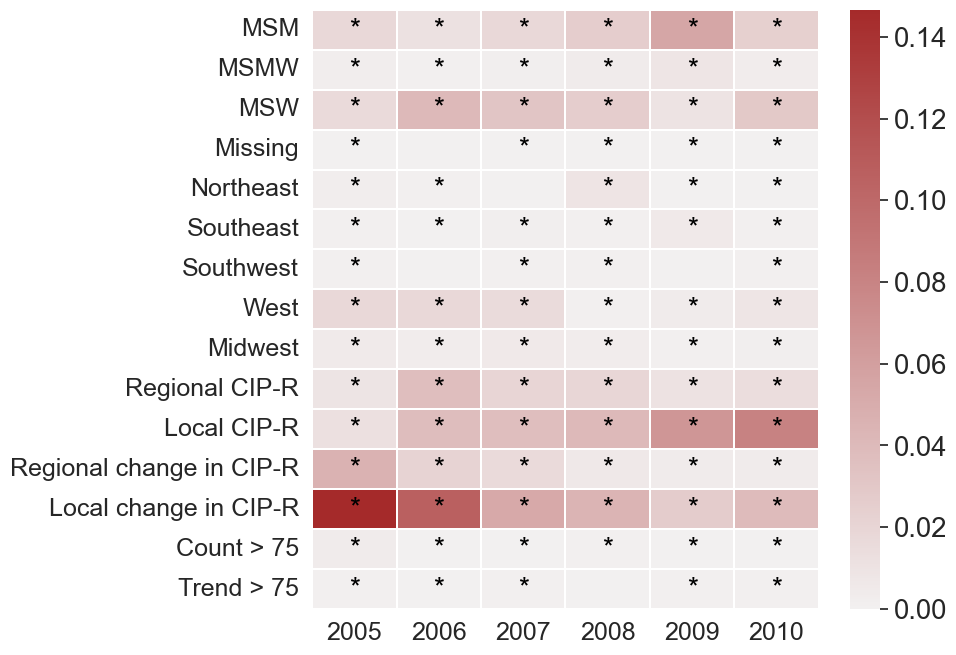

In [97]:
## Figure 1: Graph of important features only NN 

#b.light_palette("brown", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]
y_axis_labels = ['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R', 'Count > 75', 'Trend > 75']

ax.tick_params(axis='both', which='major', labelsize=18)
included_features = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

model_types = [ 2]
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

for model in model_types:
    if model == 0:
             j = 6
    elif model == 1:
             j = 12
    elif model == 2:
             j =0
    for year in test_years:
        matched_indices = np.where(np.isin(feature_names, list(set(best_features_by_year[model][year]))))[0]

        for i in matched_indices:
                ax.text(j + 0.5, i + 0.5, '*', color='black', size=20, ha='center', va='center')
        j +=1
sb.heatmap(imporances_all_models.iloc[:,0:6],fmt="",cmap=sb.light_palette("brown", as_cmap=True),linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =0, vmax = abs(imporances_all_models.max()).max())

plt.tight_layout()

#plt.show()

plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights//Magnitude_of_feature_importance_2005_2010_nn.png', dpi = 300)

In [ ]:
## Figure 1: Graph of important features - ALL


fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels = ['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R', 'Count > 75', 'Trend > 75']

ax.tick_params(axis='both', which='major', labelsize=18)
included_features = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

model_types = [0, 1, 2]
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

for model in model_types:
    if model == 0:
             j = 6
    elif model == 1:
             j = 12
    elif model == 2:
             j =0
    for year in test_years:
        matched_indices = np.where(np.isin(feature_names, list(set(best_features_by_year[model][year]))))[0]

        for i in matched_indices:
                ax.text(j + 0.5, i + 0.5, '*', color='black', size=20, ha='center', va='center')
        j +=1
sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)

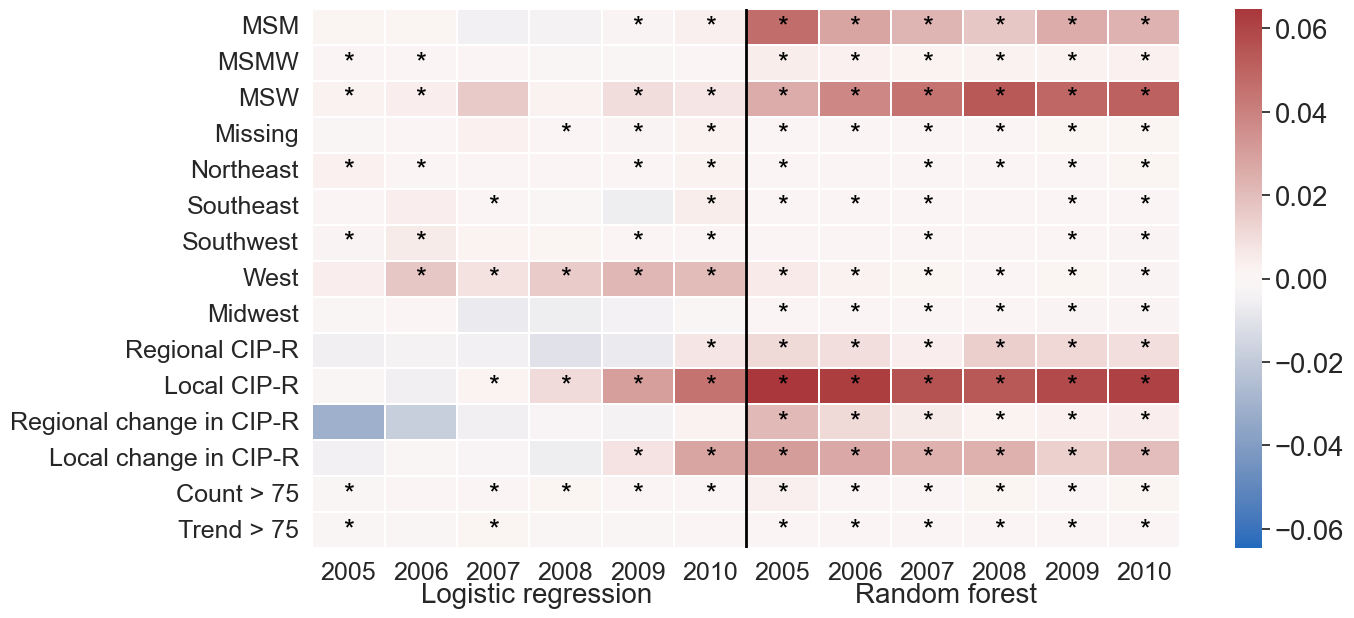

In [98]:
## Supplementary figure : Graph of important features for RF


fig, ax = plt.subplots(figsize=(14,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*2
y_axis_labels = ['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R', 'Count > 75', 'Trend > 75']

ax.tick_params(axis='both', which='major', labelsize=18)
included_features = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

model_types = [0, 1]
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

for model in model_types:
    if model == 0:
             j = 0 # if all the models were together, this would be 6
    elif model == 1:
             j = 6
 
    for year in test_years:
        matched_indices = np.where(np.isin(feature_names, list(set(best_features_by_year[model][year]))))[0]

        for i in matched_indices:
                ax.text(j + 0.5, i + 0.5, '*', color='black', size=20, ha='center', va='center')
        j +=1
sb.heatmap(imporances_all_models.iloc[:,6:],fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.iloc[:,6:].max()).max(), vmax = abs(imporances_all_models.iloc[:,6:].max()).max())
ax.text((ax.get_xlim()[1])/12 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/12 * 7.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/12 * 6, color = "black", linewidth = 2)
plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Magnitude_of_feature_importance_2005_2010_rf_lr.png', dpi = 300,   bbox_inches="tight")

# Functions for bootstrapping

In [90]:
def calculate_percentiles(iterations, ROC_actual, test_data, model_type,y_train, y_test):
        bootstrapped_stats = []
        for j in range(iterations):
            model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + "_no_weights.sav" 
            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + "_no_weights.csv" 
            ## don't need to read in weights as the model has already been trained
            X_train_bootstrap = pd.read_csv(X_data_name)
            X_train_bootstrap.drop('Unnamed: 0', inplace = True, axis = 1)
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[0:len(X_train_bootstrap.columns)]]
            if model_type == 3: #dummy
                model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) 

                model_fit = keras.models.load_model(model_name)
                y_bootstrap_predict_prob = model_fit.predict(X_test_for_bootstrap)
                ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict_prob) 

            else:
                model_fit = pickle.load(open(model_name, 'rb'))
                y_bootstrap_predict = model_fit.predict_proba(X_test_for_bootstrap)

                ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test,  y_bootstrap_predict[:,1]) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

            difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

            bootstrapped_stats.append({'Difference': difference})


        bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization
        alpha = 0.05
        upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
 ## Step 4: Get optimization-corrected performance

        return lower_quartile, upper_quartile

### now try bootstrapping w/o feature selection
iterations = 100
## DO NOT SAMPLE THE TARGET DATA
def bootstrap_auROC_no_dev(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
      #1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    for i in range(iterations):
        #2. (A) Sample all individuals from training data w/replacement

          sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          
          X_sample_train = sample_train[feature_names_with_weight]
          y_sample_train = 1 - sample_train['Susceptible']

          if model_type in [1,2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
          weights_train = np.ones(len(X_sample_train))
          X_sample_train  = X_sample_train.drop("weight", axis = 1)
        #  (B) Predictive model w/o feature selection 
          X_test_bootstrap = test_data[important_features]
          model_fit = model.fit(X_sample_train, y_sample_train)

          model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + "_no_weights.sav" 
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + "_no_weights.csv" 
          y_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + "_no_weights.csv" 
          
          X_sample_train.to_csv(X_data_name)
          y_sample_train.to_csv(y_data_name)
          pickle.dump(model_fit, open(model_name, 'wb'))
        #  (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
          y_bootstrap_predict = model_fit.predict(X_test_bootstrap)
          y_bootstrap_predict_prob = model_fit.predict_proba(X_test_bootstrap)

          ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test,  y_bootstrap_predict_prob[:,1]) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

          difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

          bootstrapped_stats.append(
          {

              'Difference': difference#,
          }
        )


    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization

    #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
    #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance
    alpha = 0.05 
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile


def bootstrap_auROC_no_dev_tensorflow(iterations, model, train_data, test_data, y_test, ROC_actual, important_features, model_type):
    # 1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    
    #for i in range(iterations):
    for i in range(iterations):
        # 2. (A) Sample all individuals from training data w/replacement
        sample_train = train_data.sample(frac = 1, replace=True)

        X_sample_train = sample_train[feature_names_with_weight]
        y_sample_train = 1 - sample_train['Susceptible']

        if model_type in [1, 2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train, y_sample_train)

        weights_train = np.ones(len(X_sample_train))
        X_sample_train = X_sample_train.drop("weight", axis=1)

        # (B) Predictive model w/o feature selection
        X_test_bootstrap = test_data[important_features]
    # Fit the model on the entire training set to get the best hyperparameters
        tuner = kt.Hyperband(model_builder,
                            objective=kt.Objective('auc', "max"),
                            max_epochs=50,
                            factor=3,
                            directory='dir',
                            project_name='x')
        tuner.search(X_train, y_train, epochs=50, callbacks=[stop_early]);
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0];
        model_nn = tuner.hypermodel.build(best_hps);
        model_nn.fit(X_sample_train, y_sample_train, epochs=10, sample_weight=weights_train, verbose=0)

        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_{model_type}_{year}_{i}"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_{model_type}_{year}_{i}_no_weights.csv"
        y_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_{model_type}_{year}_{i}_no_weights.csv"

        X_sample_train.to_csv(X_data_name)
        y_sample_train.to_csv(y_data_name)
        keras.models.save_model(model,model_name)
        # (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
        y_bootstrap_predict = model.predict(X_test_bootstrap)
        ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict)

        # (D) Calculate estimate of variance by getting (B) - (C)
        difference = ROC_AUC_bootstrap_test_performance - ROC_actual

        bootstrapped_stats.append({
            'Difference': difference
        })

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    # Step 3: Get average optimization
    lower_quartile, upper_quartile = np.percentile(bootstrapped_stats["Difference"], [2.5, 97.5])

    # Step 4: Get optimization-corrected performance
    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile

In [51]:
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]


In [29]:
CIP_data_no_drop.drop('weight_x', axis = 1, inplace = True)
CIP_data_no_drop.drop('weight_y', axis = 1, inplace = True)

In [95]:
## RF bootstrapping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

i = 0
test_years = [ 2005, 2006, 2007, 2008, 2009, 2010]
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years
    model_type = 1 
    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    #model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)
    model_name_to_load = "/Users/rem76/Documents/ML_Models/GISP_data_initial/CIP_rf_" + str(year) + "_no_weights.sav"
    model_rf = pickle.load(open(model_name_to_load, 'rb'))
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
    weights_train = np.ones(len(X_train))

    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_rf_" + str(year) + ".sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_proba[:,1])
    ROC_by_year[model_type].__setitem__(year, roc_auc_score(y_test, y_predict_proba[:,1]))
    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)
    print(ROC)
    print(lower_quartile)
    print(upper_quartile)


2005
Oversample
0.8178244111979052
0.8307429197865944
0.808829878427017
2006
Oversample
0.8328436843765796
0.8473857325566799
0.8299696598579452
2007
Oversample
0.7698604735207576
0.7876405549568897
0.7639406088149089
2008
Oversample
0.778190080058414
0.7877826231517459
0.7759216496727254
2009
Oversample
0.7497728101682131
0.7656163599225134
0.7485833863958107
2010
Oversample
0.7568635614389859
0.7667176746478157
0.7549956738094836


In [94]:
## LR boostrapping
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
 
    #model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))  
    model_name = "CIP_lr_" + str(year) + "_no_weights.sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    pickle.dump(model_lr, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_proba[:,1])
    ROC_by_year[model_type].__setitem__(year, roc_auc_score(y_test, y_predict_proba[:,1]))
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)
    

2005
2006
2007
2008
2009
2010


In [105]:
## NN boostrapping
model_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', learning_rate_init=0.001)

i = 0
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
 
    #model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    weights_train = np.ones(len(X_train))  
    model_name = "CIP_nn_" + str(year) + "_no_weights.sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    #pickle.dump(model_lr, open(model_name, 'wb'))
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_fit_train, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)

2005
Oversample
2006
Oversample
2007
Oversample
2008
Oversample
2009
Oversample
2010
Oversample


In [103]:
lower_quartile

0.7667176746478157

In [46]:
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

In [107]:
### Calculate quartiles using loaded models

years = [2005, 2006,2007, 2008, 2009, 2010]
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year_preloaded = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year_preloaded = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]

model_types = ['lr', 'rf', 'nn']

iterations = 100

for model_type in range(len(model_types)):

    for year in years: 

        test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
        y_test = 1-test_data['Susceptible']
        lower_quartile_by_year_preloaded[model_type][year], upper_quartile_by_year_preloaded[model_type][year]= calculate_percentiles(iterations, ROC_by_year[model_type][year], test_data, model_type,y_train, y_test)


In [ ]:
#imporances_all_models= pd.read_csv('imporances_all_models_with_weights_and_count_features.csv')

 auROC 

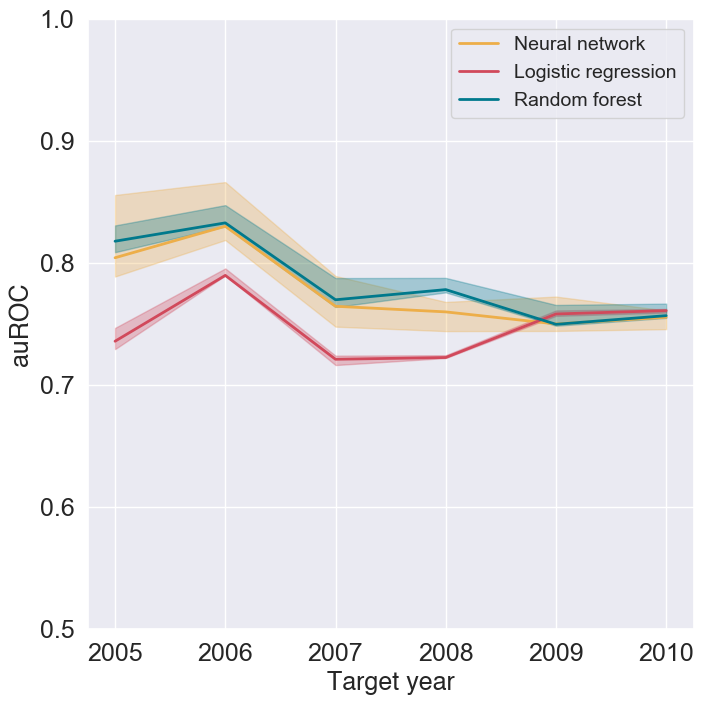

In [106]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
axs.fill_between(years, lower_quartile_by_year[2].values(), upper_quartile_by_year[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year[0].values(), upper_quartile_by_year[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year[1].values(), upper_quartile_by_year[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()

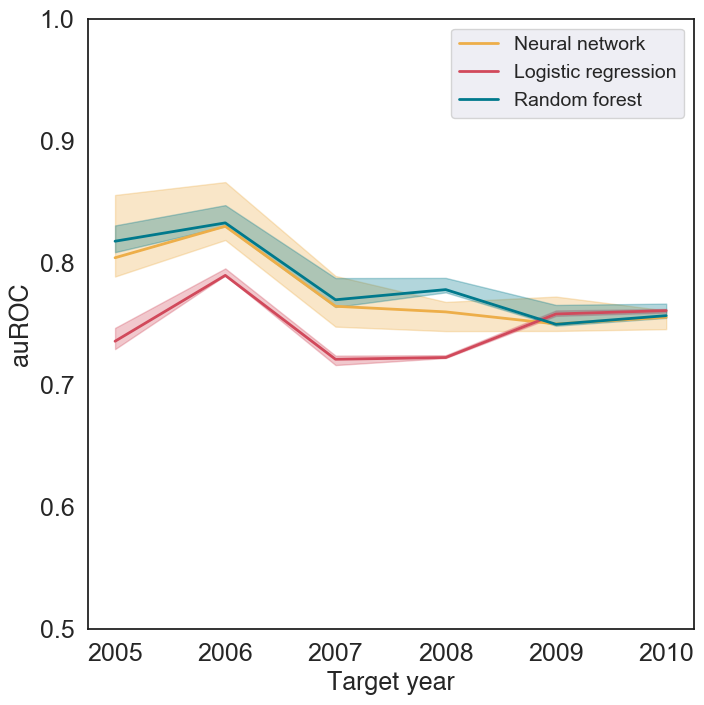

In [108]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
axs.fill_between(years, lower_quartile_by_year_preloaded[2].values(), upper_quartile_by_year_preloaded[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year_preloaded[0].values(), upper_quartile_by_year_preloaded[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year_preloaded[1].values(), upper_quartile_by_year_preloaded[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()
axs.set_facecolor('w')
for spine in axs.spines.values():
    spine.set_edgecolor('k')
plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/auROC_by_year_all_models.png', dpi = 300)



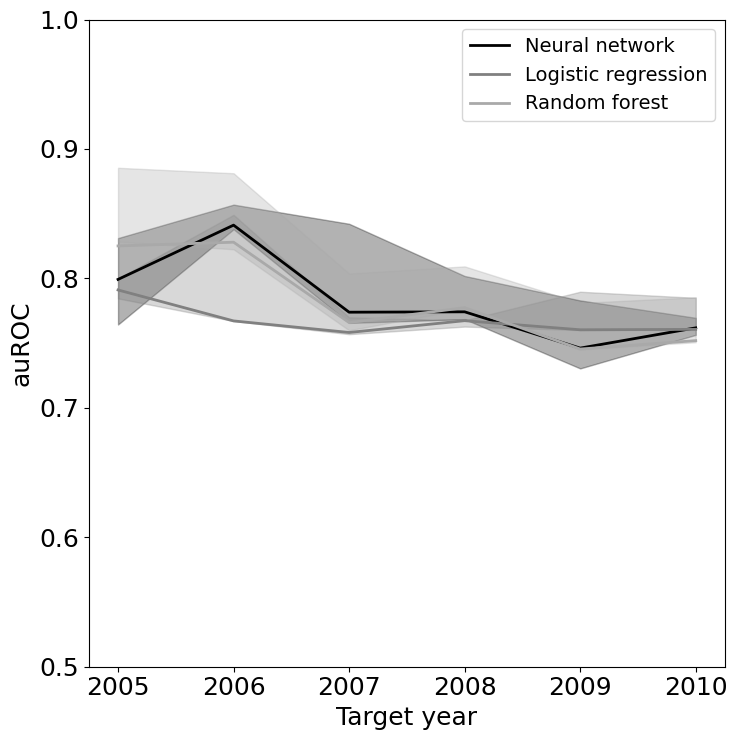

In [34]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex='all', sharey='all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
# axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(), linewidth=2, label="Neural network", color="black")
axs.fill_between(years, lower_quartile_by_year_preloaded[2].values(), upper_quartile_by_year_preloaded[2].values(), color="black", alpha=0.3)

axs.plot(years, ROC_by_year[0].values(), linewidth=2, label="Logistic regression", color="gray")
axs.fill_between(years, lower_quartile_by_year_preloaded[0].values(), upper_quartile_by_year_preloaded[0].values(), color="gray", alpha=0.3)

axs.plot(years, ROC_by_year[1].values(), linewidth=2, label="Random forest", color="darkgray")
axs.fill_between(years, lower_quartile_by_year_preloaded[1].values(), upper_quartile_by_year_preloaded[1].values(), color="darkgray", alpha=0.3)

axs.set_ylabel("auROC", fontsize=18)
axs.set_xlabel("Target year", fontsize=18)
axs.set_ylim([0.5, 1])
axs.legend(prop={'size': 14})
plt.tight_layout()
axs.set_facecolor('w')
for spine in axs.spines.values():
    spine.set_edgecolor('k')
plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/auROC_by_year_all_models_bw.png', dpi = 300)


In [52]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:
        if model_type == 2:
            y_predict_test = np.where(y_predict_proba[:, 0] > threshold, 1, 0)
        else:
            y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )

In [53]:
def effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM, prevalence_no_HI_CAL_MSM,sensitivity, specificity, prop_in_CAL_HI_MSM
):

    get_effective_threshold =   sensitivity[len(sensitivity)- 1] * prevalence_no_HI_CAL_MSM * 100 + (100 - prevalence_no_HI_CAL_MSM * 100) + prevalence_HI_CAL_MSM
    incorrectly_get_X_threshold = (1 - prevalence_HI_CAL_MSM*1)* prop_in_CAL_HI_MSM*1* (specificity[len(specificity)- 1]) # opposite to previous specificity i think 
    return (

        get_effective_threshold,
        incorrectly_get_X_threshold,
    )
def bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, actual_sensitivity, actual_specificity):
      #1. Find apparent model performance
    lower_quartile_specificity_all = []
    upper_quartile_specificity_all = []
    lower_quartile_sensitivity_all = []
    upper_quartile_sensitivity_all = []
    for threshold in threshold_seq:
      bootstrapped_stats = []

      for j in range(iterations):
            if model_type == 2:
              model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) 
              model_fit = tf.keras.models.load_model(model_name)

            else:
                model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
                model_fit = pickle.load(open(model_name, 'rb'))

            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            X_train_bootstrap = pd.read_csv(X_data_name)
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            #y_sample_predict = model_fit.predict(X_test)
            if model_type == 2: 
              y_bootstrap_predict_prob = model_fit.predict(X_test_for_bootstrap) #predicting it on the real data

              y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 0] > threshold, 1, 0)            
            else:
              y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data

              y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 1] > threshold, 1, 0)


            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = (tp_test / (tp_test + fn_test))*100
            specificity_test = (tn_test / (tn_test + fp_test))*100

          ### (D) Calculate estimate fo variance  by getting (B) - (D) 
            difference_sensitivity = sensitivity_test - actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = specificity_test - actual_specificity[np.where(threshold_seq ==threshold)[0][0]]  ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/


            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )
      alpha = 0.05
      bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

      upper_quartile_senstivity, lower_quartile_sensitivity = actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_sensitivity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
      upper_quartile_specificity, lower_quartile_specificity = actual_specificity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_specificity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])



      lower_quartile_specificity_all.append(lower_quartile_specificity)
      upper_quartile_specificity_all.append(upper_quartile_specificity)
      lower_quartile_sensitivity_all.append(lower_quartile_sensitivity)
      upper_quartile_sensitivity_all.append(upper_quartile_senstivity)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile_specificity_all, upper_quartile_specificity_all,lower_quartile_sensitivity_all,upper_quartile_sensitivity_all

def effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R, j):
          #    model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])
          if model_type == 2:
              model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) 
              model_fit = tf.keras.models.load_model(model_name)

          else:
                model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
                model_fit = pickle.load(open(model_name, 'rb'))
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
          X_train_bootstrap = pd.read_csv(X_data_name)
          X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
          #y_sample_predict = model_fit.predict(X_test)
          if model_type == 2:
              y_bootstrap_predict_prob = model_fit.predict(X_test_for_bootstrap) 
          else: 
            y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data
          sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_bootstrap_predict_prob, y_test, cipro_R)

          return sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold



# Info for plotting

In [46]:
indices = [0, 100, 200, 300, 400]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8','0.9', '1']
labels = ["A", "B", "C", "D", "E", "F" ]
labels = [label.lower() for label in labels]

# Added effective vs unnecessary 

In [52]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)

In [48]:
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

In [49]:
prop_in_CAL_HI_MSM = []
CAL_HI_MSM_by_year = []
cipro_prev_outside_CAL_HI_MSM = []
for year in test_years:
    year_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    MSM_CIPR =  (1 - year_data.loc[year_data['MSM'] == 1, 'Susceptible']).sum()
    MSW_CIPR =  (1 - year_data.loc[year_data['MSW'] == 1, 'Susceptible']).sum()
    MSMW_CIPR =  (1 - year_data.loc[year_data['MSMW'] == 1, 'Susceptible']).sum()
    Other_CIPR =  (1 - year_data.loc[year_data['Oth/Unk/Missing'] == 1, 'Susceptible']).sum()

    Not_MSM = MSW_CIPR + MSMW_CIPR + Other_CIPR
    HI_CAL =   (1 - (year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'])).sum()
    Not_CAL_HI =  (1 - (year_data[(~year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'])).sum()
    cipro_prev_outside_CAL_HI_MSM.append((Not_MSM + Not_CAL_HI)/(len(year_data)))
    CAL_HI_MSM_by_year.append((MSM_CIPR + HI_CAL)/(len(year_data)))
    prop_in_CAL_HI_MSM.append(
    (len(year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]) +
    len(year_data[(year_data['MSM'] == 1)])) /
    len(year_data)
)

KeyError: 2005

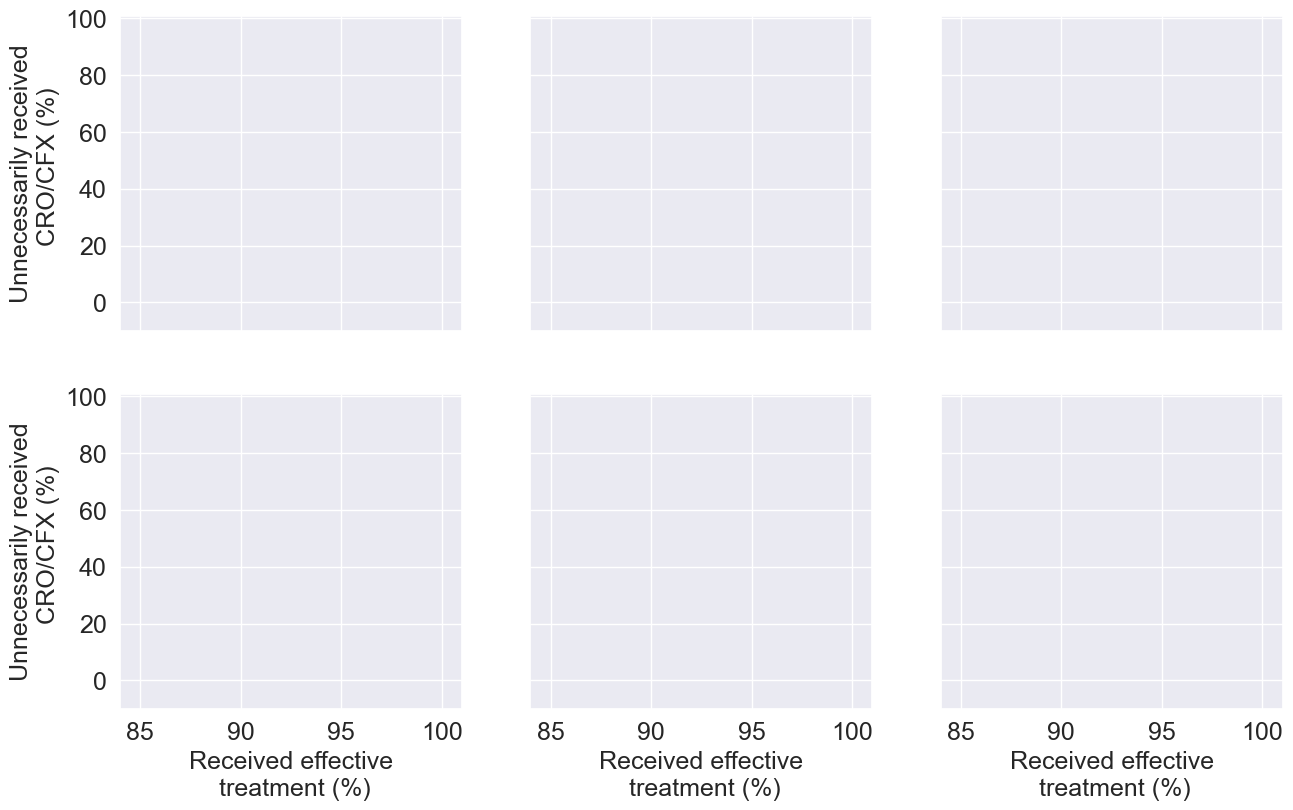

In [56]:
###### Effect of threshold on year-by-year for logistic regression with bootstrapping
iterations = 100
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4'] #, '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0, 100, 200, 300, 400] #, 500, 600, 700, 800, 900, 1000]
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)


axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_lr = []
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]

for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))  


    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_lr.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)

        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Only CRO or CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Only CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM= prop_in_CAL_HI_MSM[i])[0]
        unnecessary_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM = prop_in_CAL_HI_MSM[i])[1]
        #axs[i].plot([effective_with_CDC_rules,100], [unnecessary_with_CDC_rules,(1-cipro_R_prev)*100], color = "#D7BCE8", linestyle=":", linewidth=4)

        axs[i].plot(effective_with_CDC_rules, unnecessary_with_CDC_rules, marker='x', ls='none', ms=14, color = "black", label = 'HI, CA, MSM: CRO/CFX; Rest:CIP')


    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")


    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45,  f'auROC: {ROC_by_year[model_type][year]:.2f}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 55, f'CIP-R: {round(cipro_R_prev*100, 1)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')

# Create a legend for the first subplot (axs[0]) and place it at the bottom
legend = axs[0].legend(prop={'size': 14}, loc='lower center', bbox_to_anchor=(1.75, -1.75), ncol = 3)

# Set the legend's frame color to white
legend.get_frame().set_facecolor('white') 
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
#plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Percent_effective_unnecessary_all_logistic_regression_2005_2010_weights_extra_features.png', dpi = 300)


Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


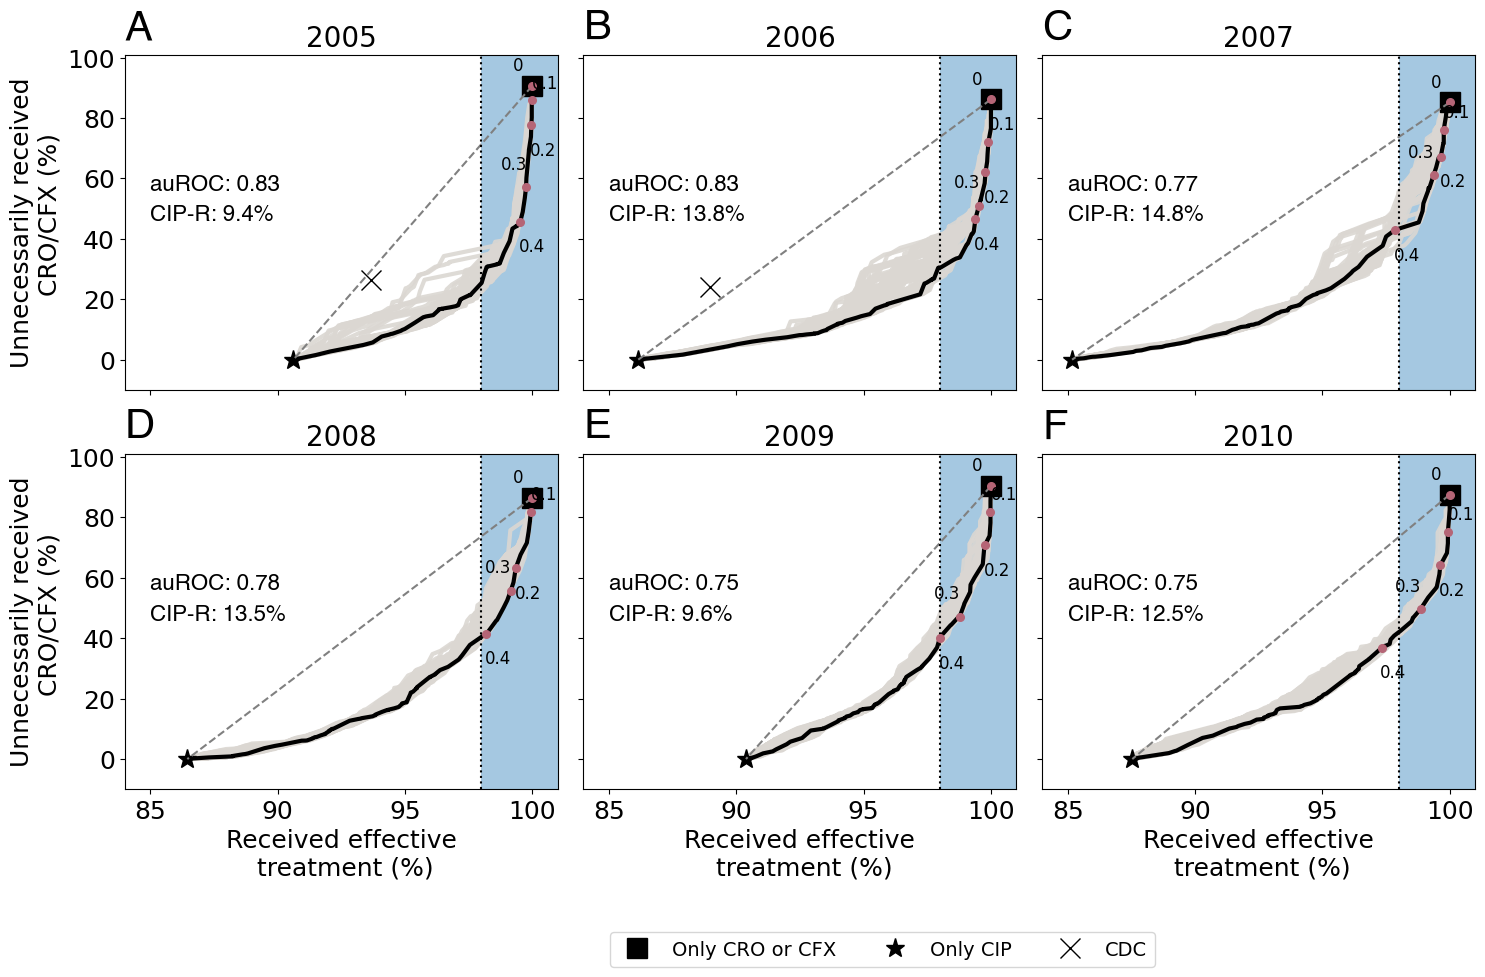

In [54]:
###### Effect of threshold on year-by-year for random forest model with bootstrap
from matplotlib.patches import Polygon
iterations = 100
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])


axs = axs.ravel()

cip_R_all_years = []
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_rf = []
i = 0
for year in years:
    model_type =1 
    years_train = np.array(range(year - 5, year))
    
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)

    sample_weights = np.ones(len(X_train))
    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    #plot
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_rf.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)
        if(len(incorrectly_get_X_threshold_sample) == len(incorrectly_get_X_threshold)):
            axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Only CRO or CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Only CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM= prop_in_CAL_HI_MSM[i])[0]
        unnecessary_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM = prop_in_CAL_HI_MSM[i])[1]
        #axs[i].plot([effective_with_CDC_rules,100], [unnecessary_with_CDC_rules,(1-cipro_R_prev)*100], color = "#D7BCE8", linestyle=":", linewidth=4)

        axs[i].plot(effective_with_CDC_rules, unnecessary_with_CDC_rules, marker='x', ls='none', ms=14, color = "black", label = 'CDC')


    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45,  f'auROC: {ROC_by_year[model_type][year]:.2f}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 55, f'CIP-R: {round(cipro_R_prev*100, 1)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle=":")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

plt.tight_layout()
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')

# Create a legend for the first subplot (axs[0]) and place it at the bottom
legend = axs[0].legend(prop={'size': 14}, loc='lower center', bbox_to_anchor=(1.75, -1.75), ncol = 3)

# Set the legend's frame color to white
legend.get_frame().set_facecolor('white') 
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Percent_effective_unnecessary_all_random_forest_2005_2010_bootstrap_weights_extra_features.png', dpi = 300)

Oversample
194/194 [==============================] - 0s 305us/step
Oversample
191/191 [==============================] - 0s 216us/step
Oversample
188/188 [==============================] - 0s 209us/step
Oversample
179/179 [==============================] - 0s 214us/step
Oversample
176/176 [==============================] - 0s 216us/step
Oversample
178/178 [==============================] - 0s 214us/step


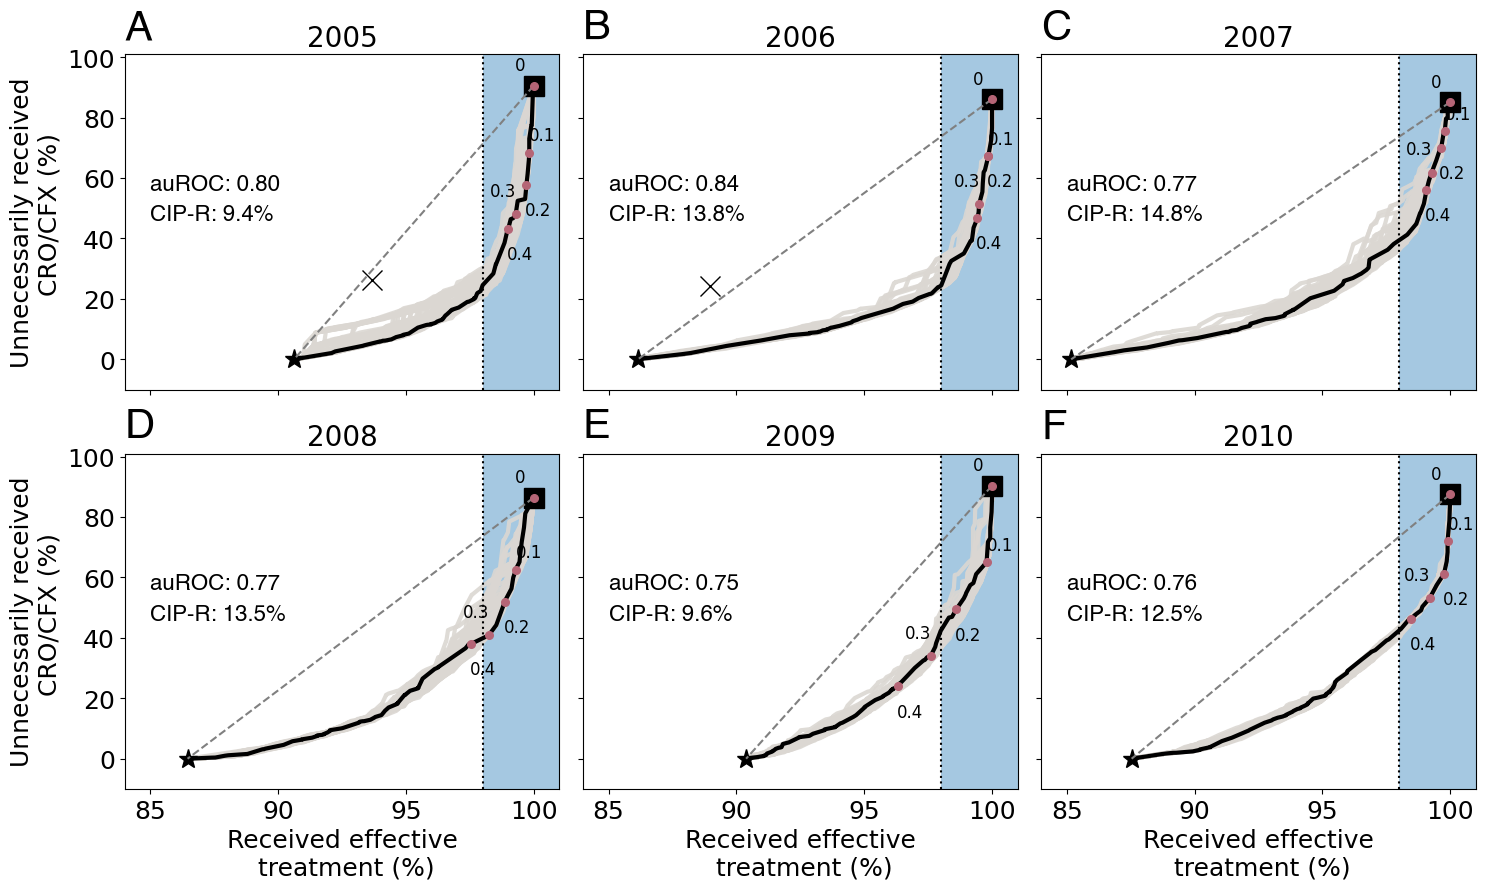

In [55]:
###### Effect of threshold on year-by-year for neural network model with bootstrap
from matplotlib.patches import Polygon
iterations = 100
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])


axs = axs.ravel()

cip_R_all_years = []
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_nn = []
i = 0
for year in years:
    model_type =2 
    years_train = np.array(range(year - 5, year))
    
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))

    model_name = "CIP_nn_" + str(year) + "no_weights.sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    #plot
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_nn.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)
        if(len(incorrectly_get_X_threshold_sample) == len(incorrectly_get_X_threshold)):
            axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Only CRO or CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Only CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM= prop_in_CAL_HI_MSM[i])[0]
        unnecessary_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold, prop_in_CAL_HI_MSM = prop_in_CAL_HI_MSM[i])[1]
        #axs[i].plot([effective_with_CDC_rules,100], [unnecessary_with_CDC_rules,(1-cipro_R_prev)*100], color = "#D7BCE8", linestyle=":", linewidth=4)

        axs[i].plot(effective_with_CDC_rules, unnecessary_with_CDC_rules, marker='x', ls='none', ms=14, color = "black", label = 'CDC')


    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45,  f'auROC: {ROC_by_year[model_type][year]:.2f}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 55, f'CIP-R: {round(cipro_R_prev*100, 1)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle=":")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

plt.tight_layout()
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')

# Create a legend for the first subplot (axs[0]) and place it at the bottom
legend = axs[0].legend(prop={'size': 14}, loc='lower center', bbox_to_anchor=(1.75, -1.75), ncol = 3)

# Set the legend's frame color to white
legend.get_frame().set_facecolor('white') 
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Percent_effective_unnecessary_all_neural_network_2005_2010_bootstrap_no_weights_extra_features.png', dpi = 300)


In [392]:
## how many unnecessarily get CRO or CFX at the 98% efficacy under the model predictions
unneccessary_treatment_98_efficacy_nn 

[28.610618040987575,
 25.952693823915904,
 38.642036944583126,
 39.45483138214223,
 37.51778093883357,
 42.99525399894534]

In [462]:
def reduction_in_unnecessary(mu_t, theta_prime):
    omega_prime = (1 - mu_t) / mu_t * (mu_t + theta_prime - 1)
    return omega_prime

In [419]:
cip_prev_by_year_all = [9.376, 13.847, 14.828, 13.542, 9.619, 12.463]
cipro_prev_outside_CAL_HI_MSM #outside cal, HI, MSM 
CAL_HI_MSM_by_year # inside CAL, HI, MSM 
theta_prime = 0.98

In [475]:
unnecessary_CAL_HI_MSM = []

for CIPR in CAL_HI_MSM_by_year:
    unnecessary_CAL_HI_MSM.append(reduction_in_unnecessary(CIPR, .98)*100)

unnecessary_not_CAL_HI_MSM = []

for CIPR in cipro_prev_outside_CAL_HI_MSM:
    unnecessary_not_CAL_HI_MSM.append(reduction_in_unnecessary(CIPR, .98)*100)

unnecessary_all = []

for CIPR in cip_prev_by_year_all:
    unnecessary_all.append(reduction_in_unnecessary(CIPR/100, .98)*100)



In [481]:
(prop_in_CAL_HI_MSM[0]*unnecessary_CAL_HI_MSM[0] + (1-prop_in_CAL_HI_MSM[0])*unnecessary_not_CAL_HI_MSM[0])

64.88398575570592

In [482]:
## for 2005 and 2006, need to weight 

red_2005 = (prop_in_CAL_HI_MSM[0]*unnecessary_CAL_HI_MSM[0] + (1-prop_in_CAL_HI_MSM[0])*unnecessary_not_CAL_HI_MSM[0]) - unneccessary_treatment_98_efficacy_nn[0]
red_2006 = (prop_in_CAL_HI_MSM[1]*unnecessary_CAL_HI_MSM[1] + (1-prop_in_CAL_HI_MSM[1])*unnecessary_not_CAL_HI_MSM[1]) - unneccessary_treatment_98_efficacy_nn[1]
red_2007 = unnecessary_all[2] - unneccessary_treatment_98_efficacy_nn[2]
red_2008 = unnecessary_all[3] - unneccessary_treatment_98_efficacy_nn[3]
red_2009 = unnecessary_all[4] - unneccessary_treatment_98_efficacy_nn[4]
red_2010 = unnecessary_all[5] - unneccessary_treatment_98_efficacy_nn[5]



In [484]:
red_2005

36.27336771471835

In [483]:
mean_red = np.mean([red_2005, red_2006, red_2007, red_2008, red_2009, red_2010], axis=0)
mean_red

36.10650779218462

# SI Graphs

Senistivity and specificity

Functions for SI

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


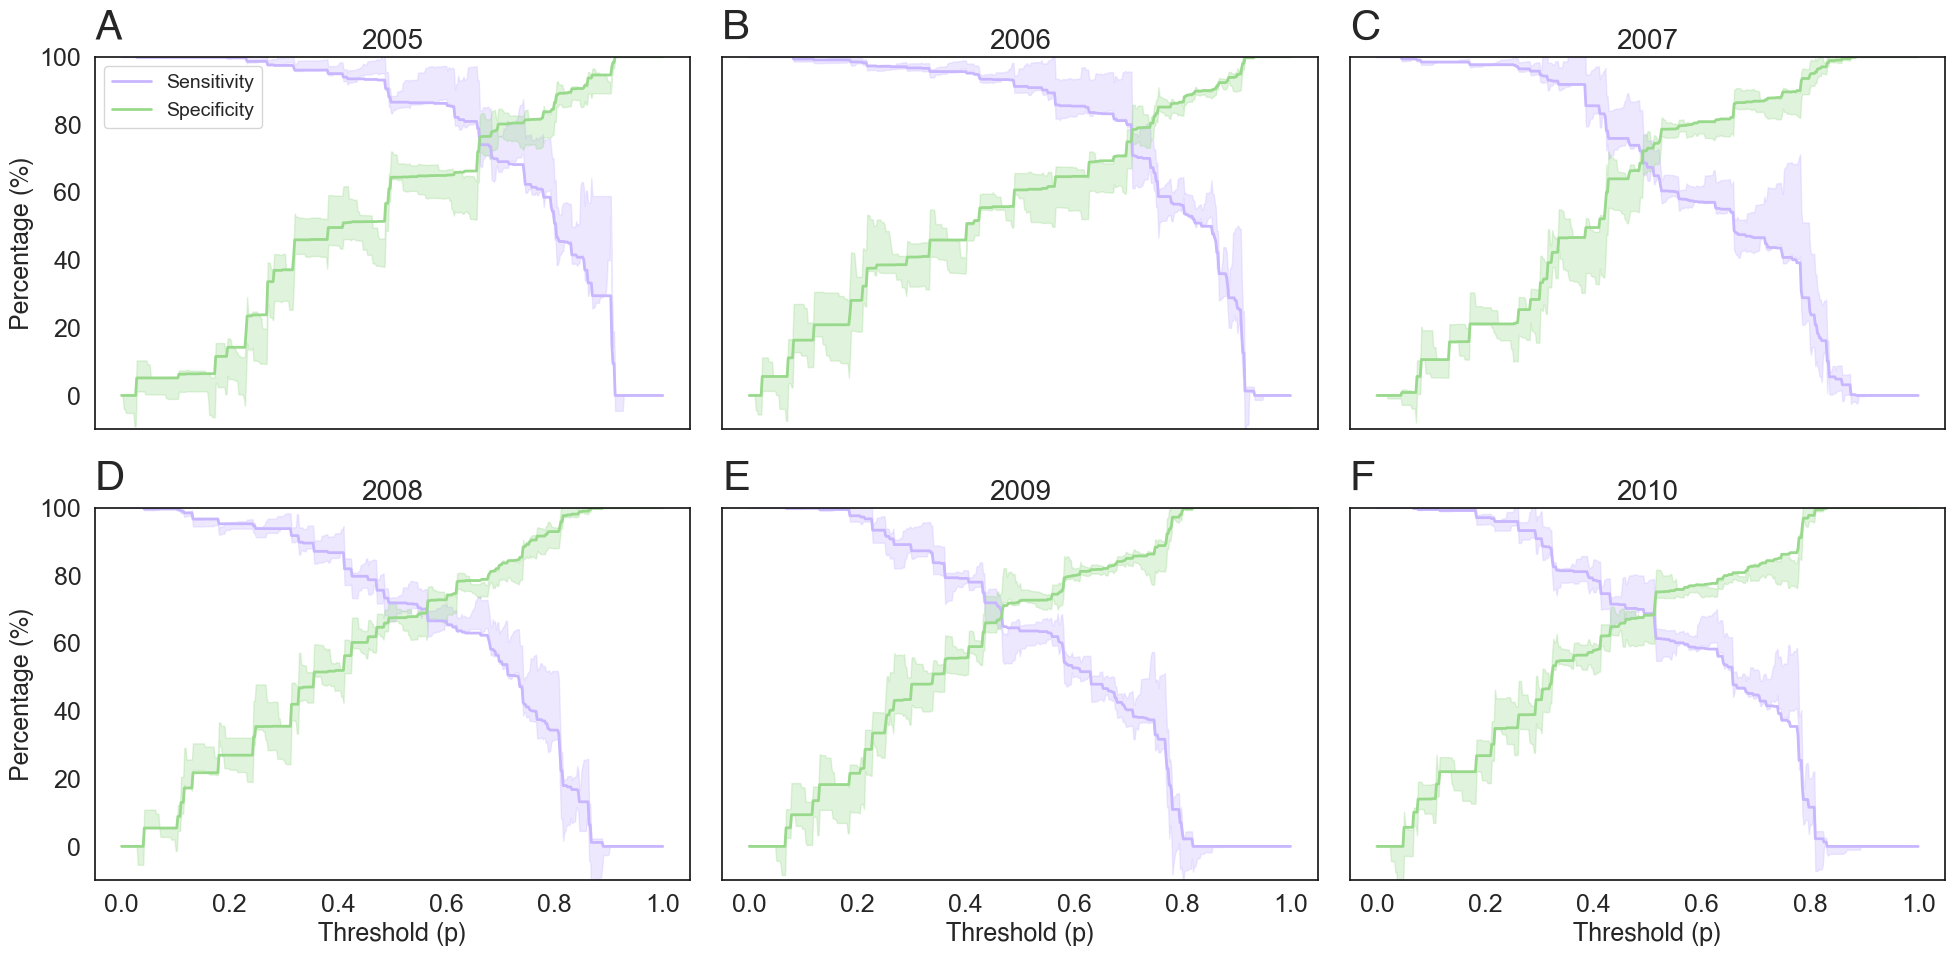

In [377]:
### RF Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))

    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

plt.savefig("/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

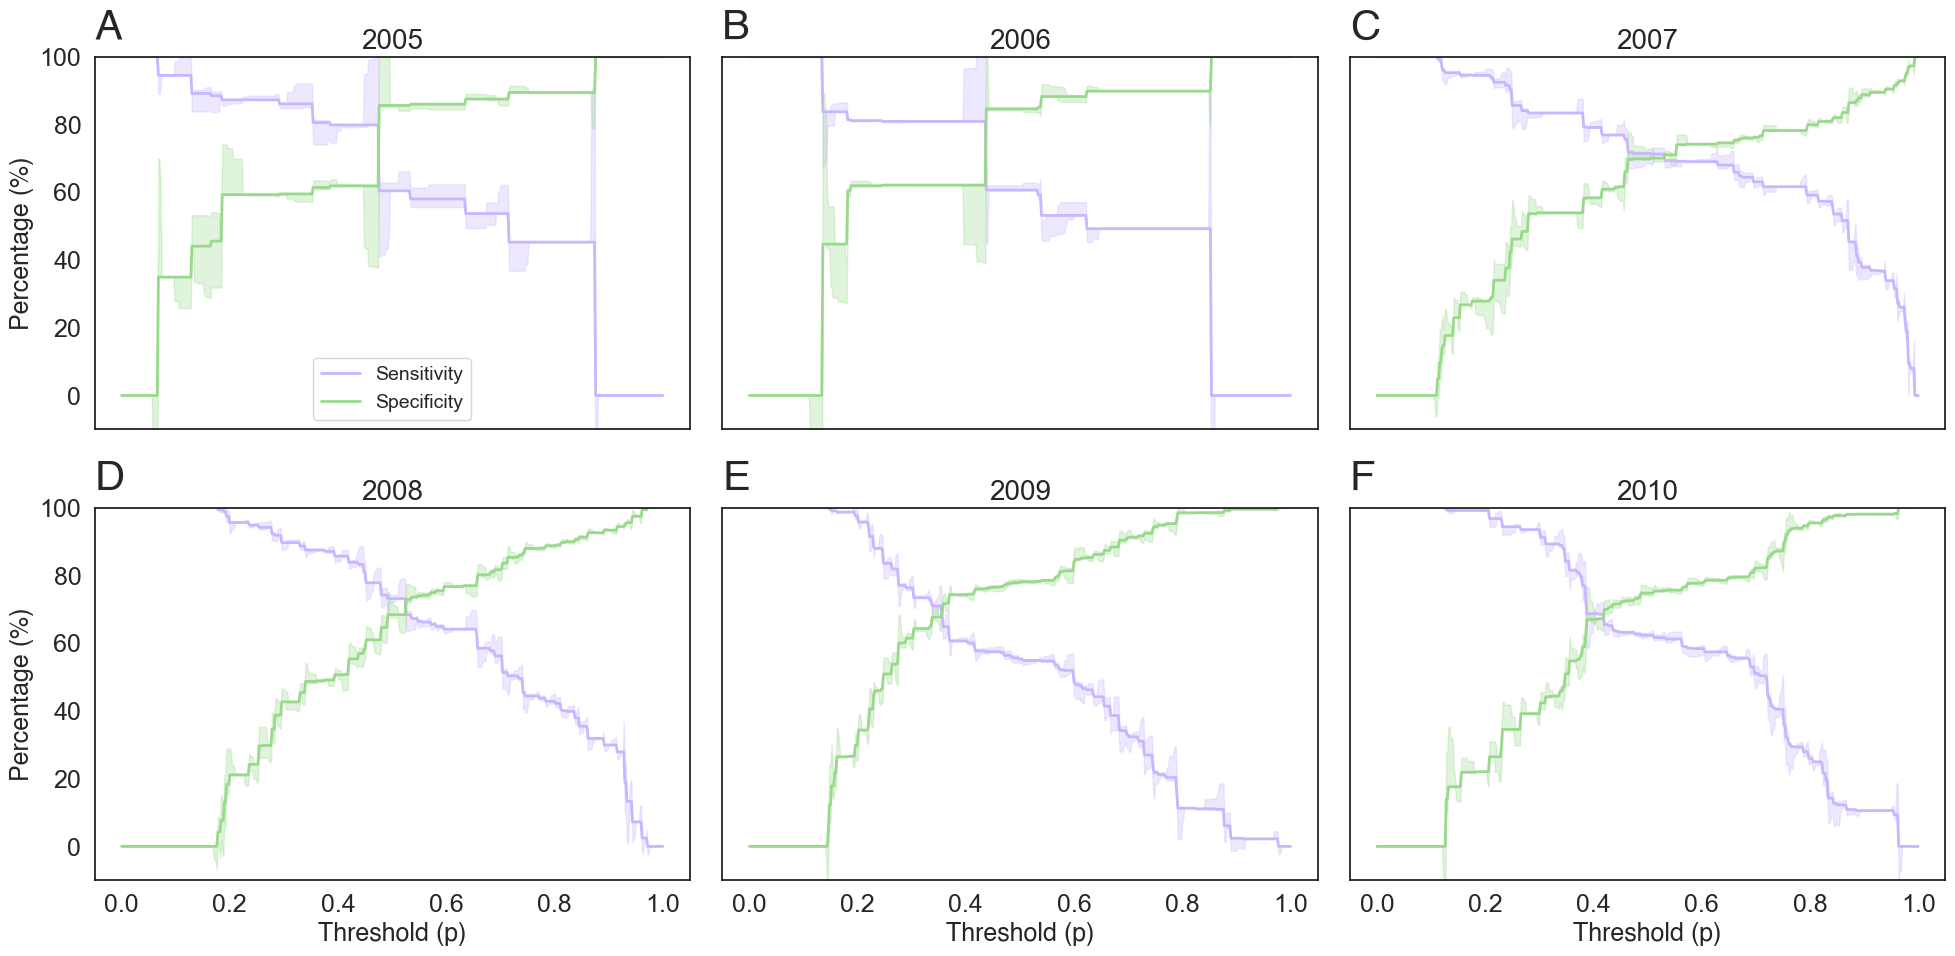

In [378]:
### LR Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)

i = 0
for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year[model_type][year]
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = 0)
    sample_weights = np.ones(len(X_train))
    
    ## fit model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

plt.savefig("/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

In [ ]:
### NN Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))  

    model_name = "CIP_nn_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()

plt.savefig("/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/Sensitivity_specificity_all_workflow_paper_neural_network_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

# LOOCV 

In [50]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        if model_type == 2:
            y_predict_test = np.where(y_predict_proba[:, 0] > threshold, 1, 0)
        else:
            y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )


In [489]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


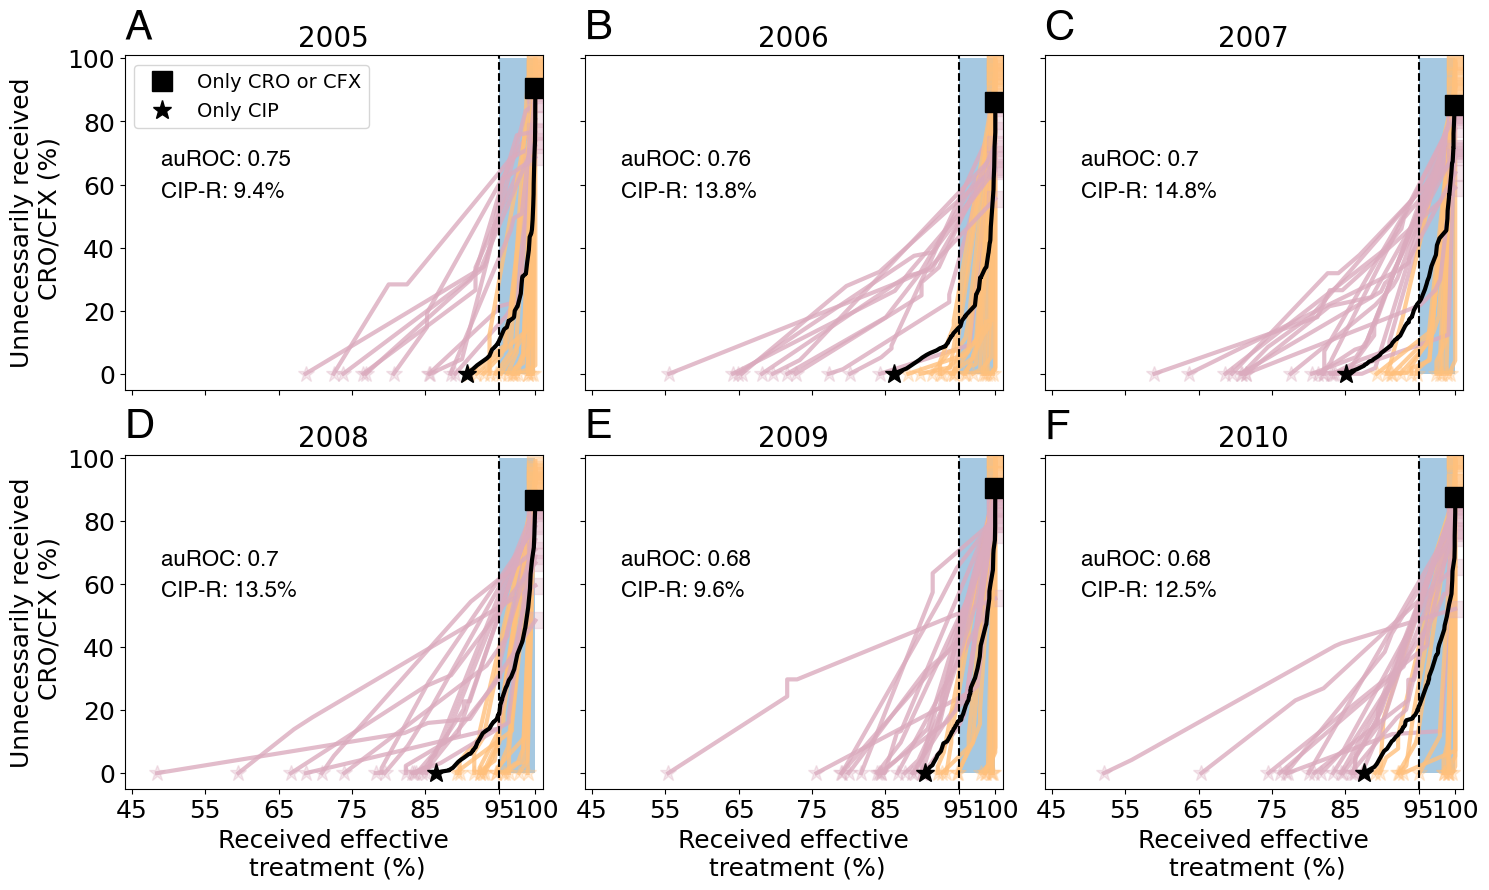

In [105]:
### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

##"full model"
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))
    model_type = 1
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))
    ## Load saved model
    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.8
          else:
              col = '#ffc07c'
              alpha_graph = 0.8

          try:
          # test 
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:
              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Only CRO or CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Only CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 2)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45,  f'CIP-R: {round(cipro_R_prev*100, 1)}%', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #


axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  

for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig("/Users/rem76/Documents/ML_Models/Graphs_for_no_weights//LOOCV_effective_unnecessary_all_workflow_paper_random_forest_2005_2010_coloured.png", dpi = 300)

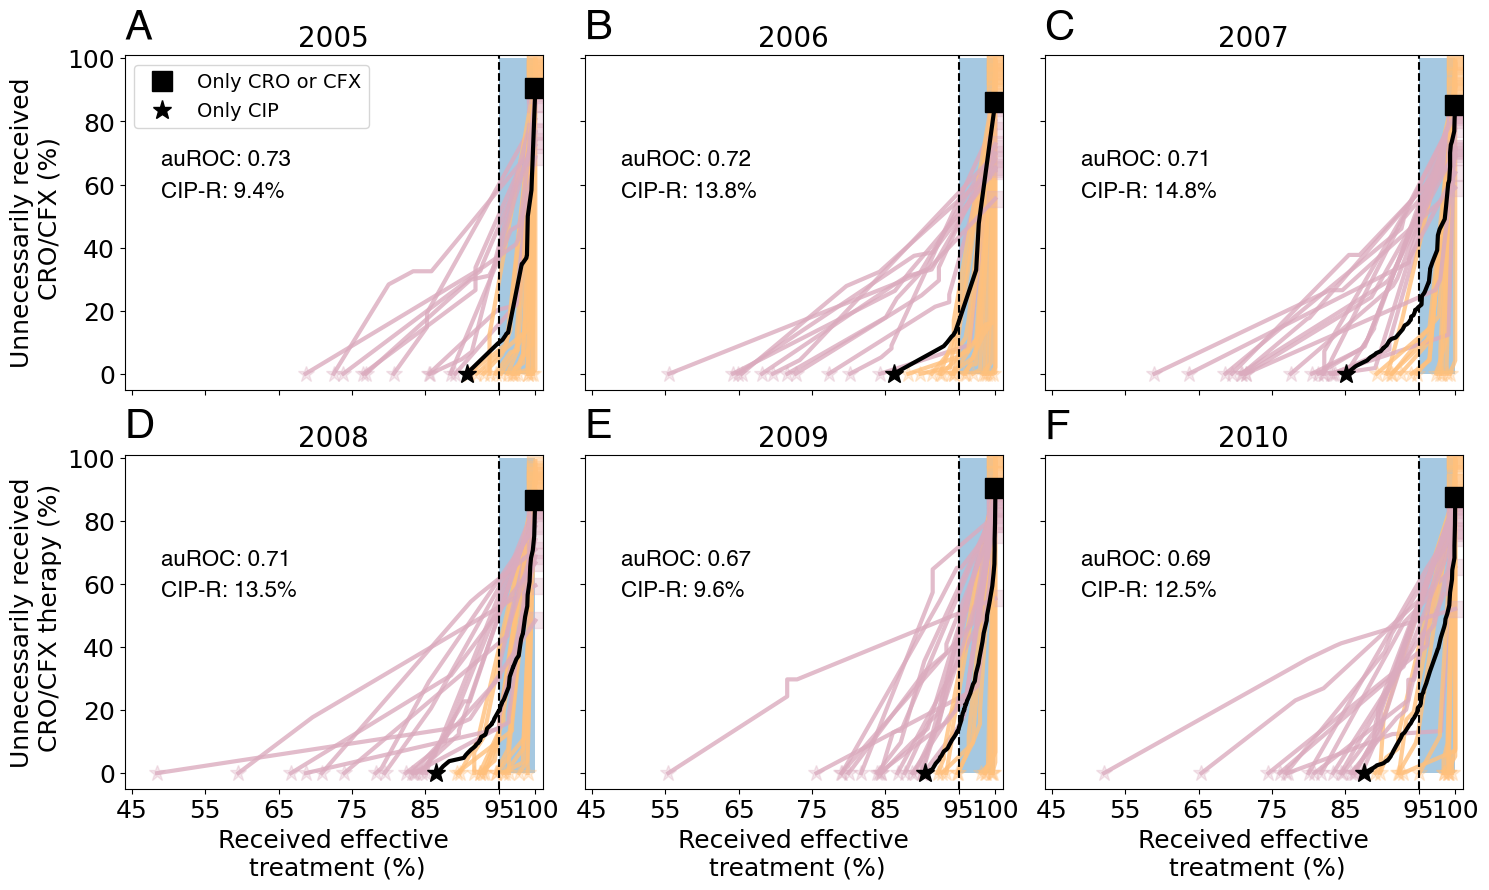

In [106]:
### Leave one out validation for logistic regression 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
threshold_seq = np.linspace(0,1,1001)

years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    model_type = 0
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))
    ## Load saved model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
            
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Only CRO or CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Only CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 2)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45,  f'CIP-R: {round(cipro_R_prev*100, 1)}%', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig("/Users/rem76/Documents/ML_Models/Graphs_for_no_weights//LOOCV_effective_unnecessary_all_workflow_paper_logistic_regression_2005_2010_coloured.png", dpi = 300)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


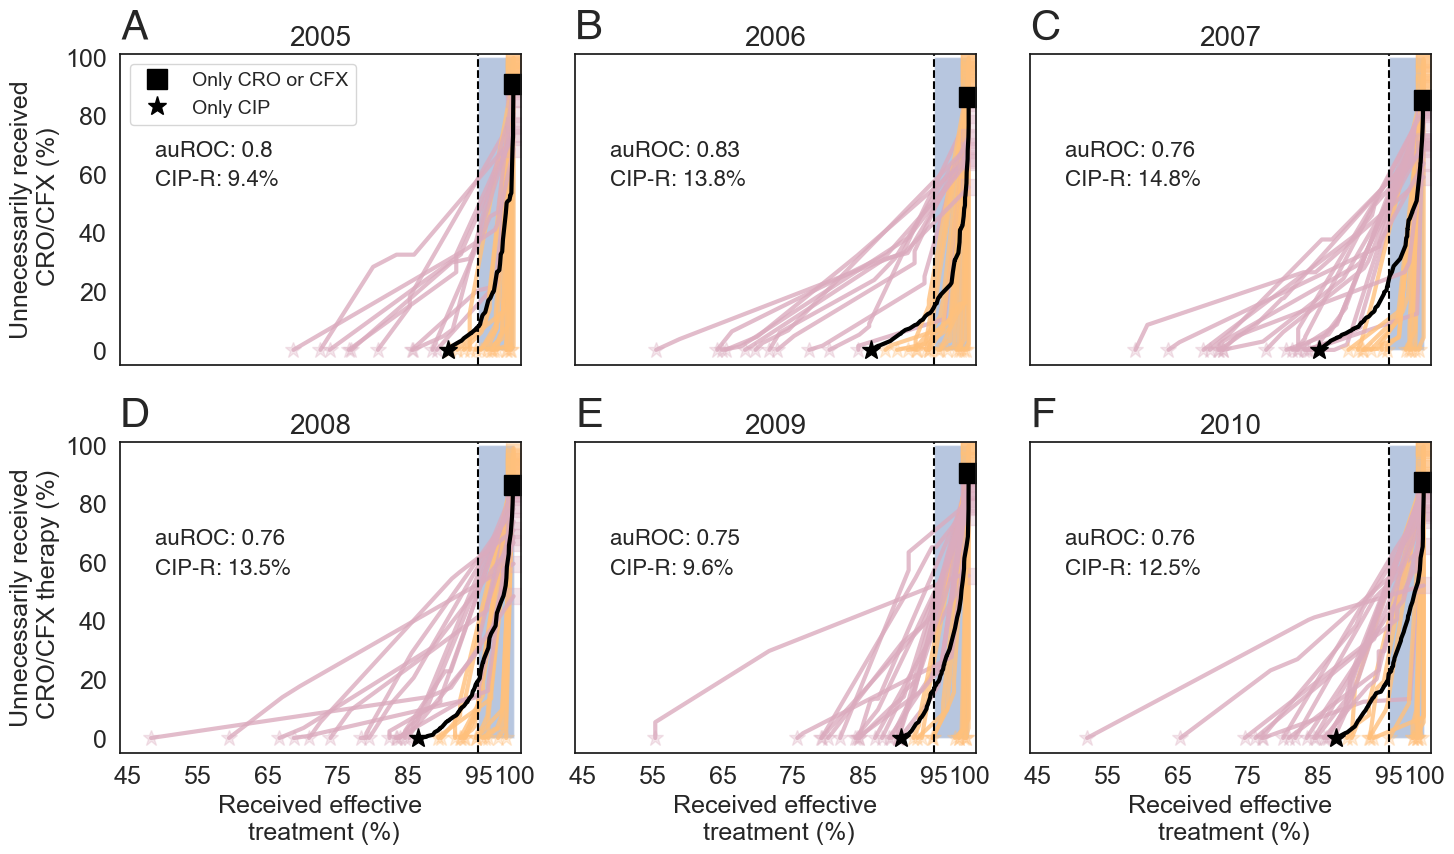

In [117]:
### Leave one out validation for neural network
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
threshold_seq = np.linspace(0,1,1001)

years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    model_type = 2
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    sample_weights = np.ones(len(X_train))
    ## Load saved model
    model_name = "CIP_nn_" + str(year) + "_no_weights.sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
            
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "Only CRO or CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Only CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 2)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45,  f'CIP-R: {round(cipro_R_prev*100, 1)}%', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig("/Users/rem76/Documents/ML_Models/Graphs_for_no_weights//LOOCV_effective_unnecessary_all_workflow_paper_neural_network_2005_2010_coloured.png", dpi = 300)

In [116]:
CIP_data_no_drop.drop('weight_x', axis = 1, inplace = True)
CIP_data_no_drop.drop('weight_y', axis = 1, inplace = True)

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


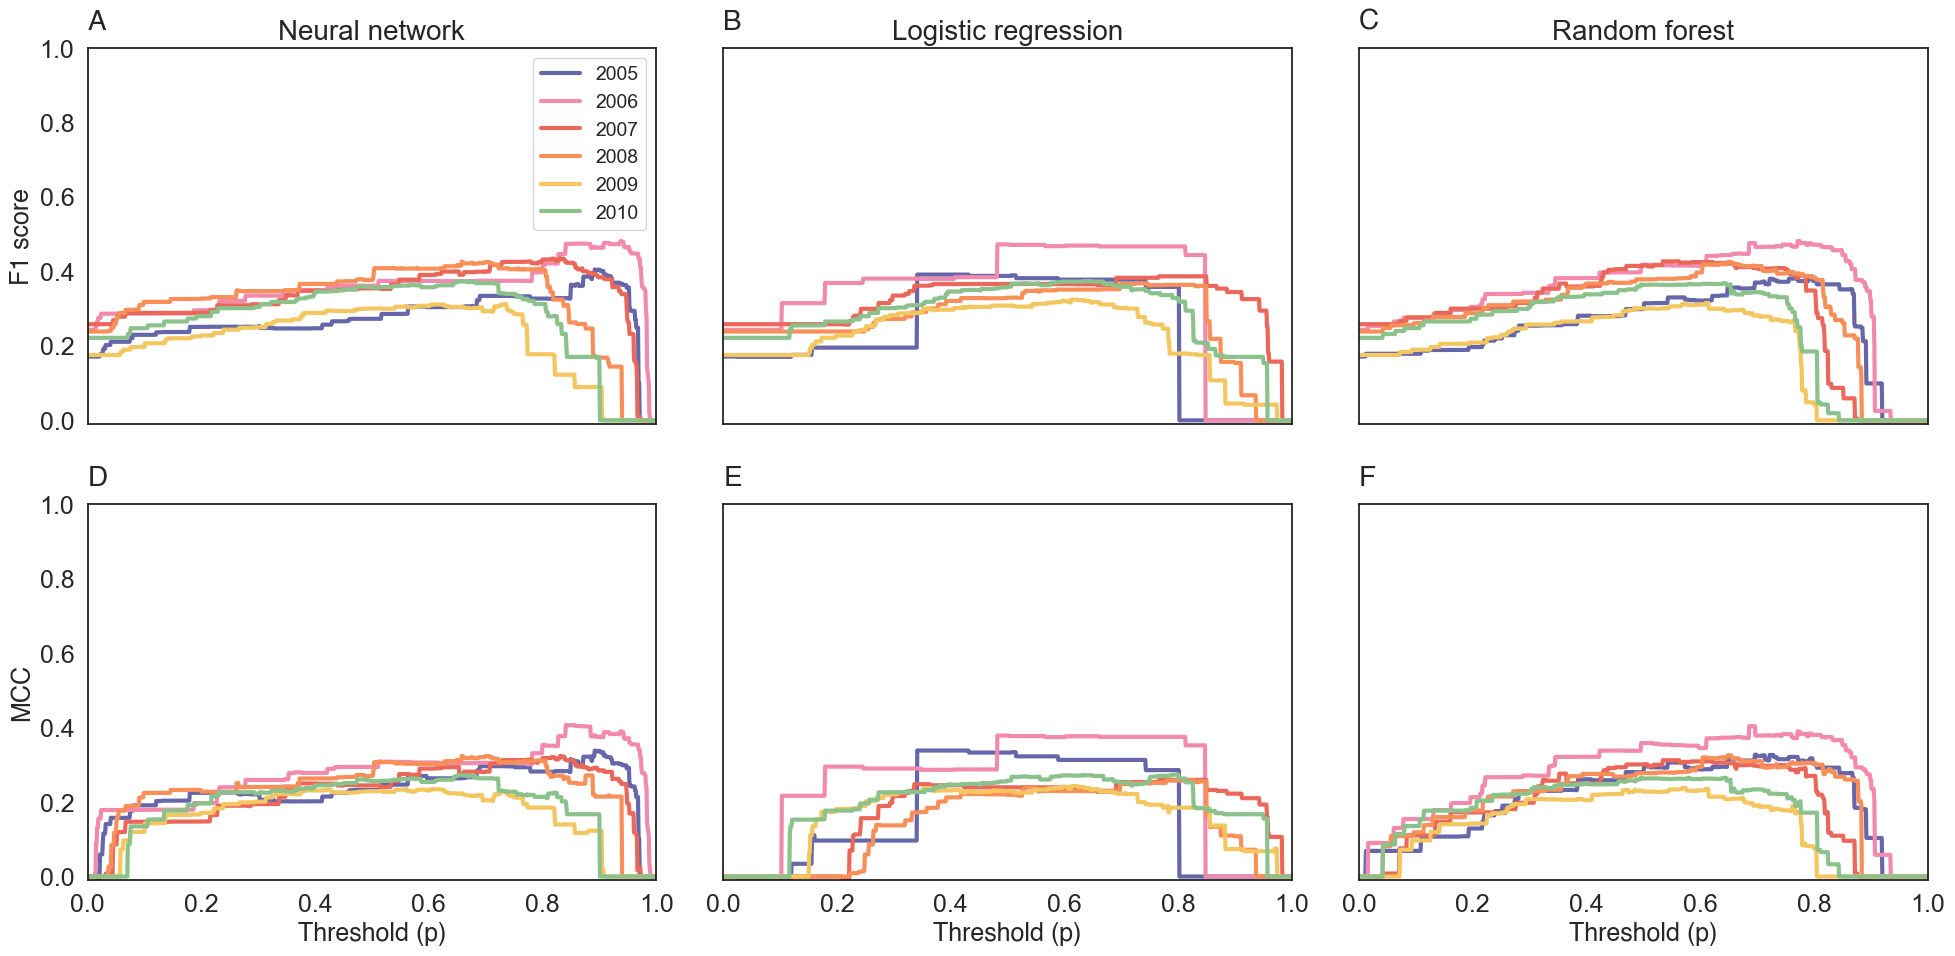

In [113]:
###### Performance criteria by year and model 
def f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type):

    f1_score_seq = []
    mcc_score_seq = []
    for threshold in threshold_seq:
        if model_type == 2:
             y_predict = np.where(y_predict_proba[:, 1] > threshold, 1, 0)
        else:
            y_predict = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        f1_score_seq.append(f1_score(y_test, y_predict))
        mcc_score_seq.append(matthews_corrcoef(y_test, y_predict))
    return(f1_score_seq, mcc_score_seq)

## set up for figure 
threshold_seq = np.linspace(0,1,1001)

### calculate scores 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ["#6667ab", "#f18aad", "#ea6759", "#f88f58", "#f3c65f", "#8bc28c"]
labels = ["A", "B", "C", "D", "E", "F" ]

test_years = [2005, 2006, 2007, 2008, 2009, 2010]

axs[0,0].set_ylabel('F1 score', fontsize = 18, **hfont)
axs[1,0].set_ylabel('MCC', fontsize = 18, **hfont)
axs[1,0].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,1].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,2].set_xlabel("Threshold (p)", fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_ylim([0-.010,1])
axs[0,0].set_xlim([0, 1])

axs = axs.ravel()

for i in range(3):
    x = 0

    if i == 0:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_type = 2
            CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
            CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
            # first do for all clinics 
            counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
            counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

            merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

            # Calculate the sum of all counts in the counts dataframe
            total_counts = counts['Count'].sum()

            # Calculate the 'weight' column as Count_counts / total_counts
            merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
            # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

            # Merge the 'weight' column back to the original DataFrame
            CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
            # first do for all clinics 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
            sample_weights = np.ones(len(X_train))
            model_name = "CIP_nn_" + str(year) + "_no_weights.sav" 
            model_fit_train = pickle.load(open(model_name, 'rb'))
            ## fit model w/hyperparameters 
            y_predict_proba = model_fit_train.predict_proba(X_test)

            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type )
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3)
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Neural network",fontsize=20)
        axs[i].legend()


    if i == 1:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_type = 0
            CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
            CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
            # first do for all clinics 
            counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
            counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

            merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

            # Calculate the sum of all counts in the counts dataframe
            total_counts = counts['Count'].sum()

            # Calculate the 'weight' column as Count_counts / total_counts
            merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
            # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

            # Merge the 'weight' column back to the original DataFrame
            CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
            # first do for all clinics 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


            # first do for all clinics 

            model_name = "CIP_lr_" + str(year) + "_no_weights.sav" 
            model_fit_train = pickle.load(open(model_name, 'rb'))
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

            x += 1
   
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Logistic regression",fontsize=20)

    
    if i == 2:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_type = 1
            CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
            CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
            # first do for all clinics 
            counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
            counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

            merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

            # Calculate the sum of all counts in the counts dataframe
            total_counts = counts['Count'].sum()

            # Calculate the 'weight' column as Count_counts / total_counts
            merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
            # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

            # Merge the 'weight' column back to the original DataFrame
            CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
            # first do for all clinics 
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
            sample_weights = np.ones(len(X_train))
            model_name = "CIP_rf_" + str(year) + "_no_weights.sav" 
            model_fit_train = pickle.load(open(model_name, 'rb'))
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test, model_type)

            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)
            CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Random forest",fontsize=20)
legend  = axs[0].legend(prop={'size':14})
legend.get_frame().set_facecolor('white')  


for ax in axs.ravel():
    ax.set_facecolor('w')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
plt.tight_layout()
plt.savefig('/Users/rem76/Documents/ML_Models/Graphs_for_no_weights/F1_MCC_score_all_years_all_models.png', dpi = 300)
